# Importing Libraries

In [661]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import networkx as nx
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from nrclex import NRCLex
from sklearn.decomposition import PCA

# Importing Data

In [273]:
df = pd.read_csv("parasite_script.csv")
df.head(5)

,Scene Number,Setting,Scene
0,1,TITLE SEQUENCE OVER BLACK,Accompanied by dark but curiously upbeat MUSIC...
1,2,INT. SEMI-BASEMENT - DAY,"A dank semi-basement apartment. KI-WOO, 24, ru..."
2,3,INT. SEMI-BASEMENT - LATER,The family sits among piles of UNASSEMBLED PIZ...
3,4,INT/EXT. SEMI-BASEMENT - ENTRANCE - LATE AFTER...,"Through the half-open door, we see the female ..."
4,5,INT. SEMI-BASEMENT - EARLY EVENING,The ‘master bedroom’ next to the entrance. Wal...


# Initial EDA - Scene and Setting Length

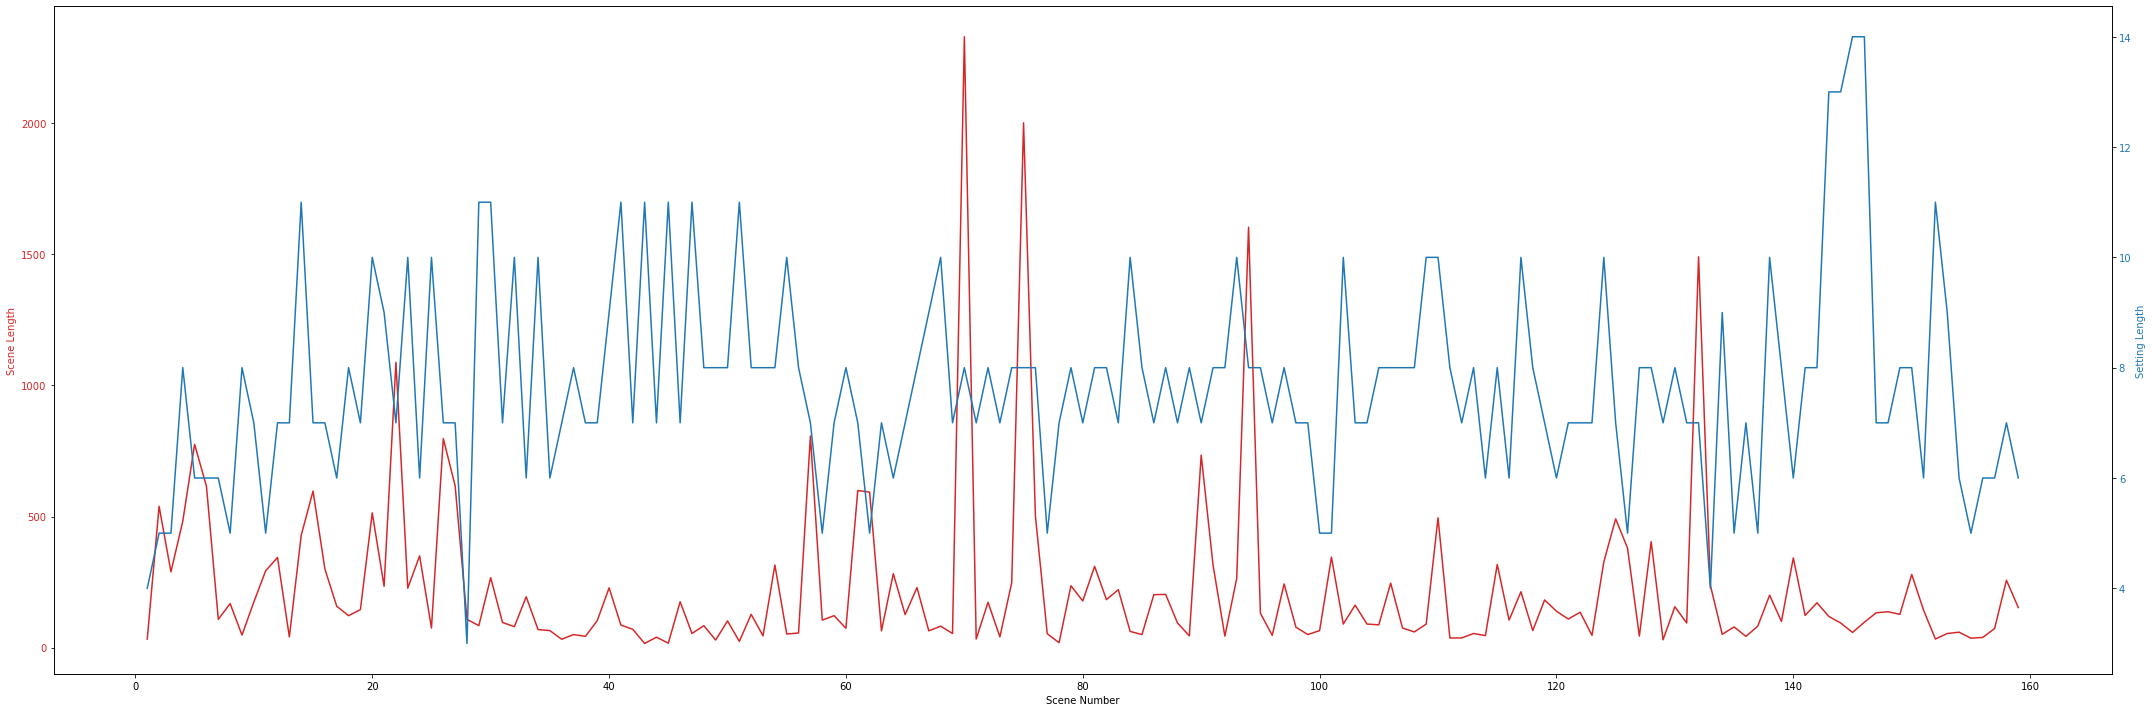

In [595]:
df_eda = df.copy()

# counting the scene and setting length through word count
df_eda["Setting Length"] = 0
df_eda["Scene Length"] = 0

for i in range(len(df_eda)):
    setting_tokens = word_tokenize(df_eda.iloc[i, 1])
    scene_tokens = word_tokenize(df_eda.iloc[i, 2])
    
    df_eda.iloc[i, 3] = len(setting_tokens)
    df_eda.iloc[i, 4] = len(scene_tokens)

# plotting scene and setting length throughout the film
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
ax1.set_xlabel('Scene Number')
ax1.set_ylabel('Scene Length', color=color)
ax1.plot(df_eda["Scene Number"], df_eda["Scene Length"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Setting Length', color=color)  # we already handled the x-label with ax1
ax2.plot(df_eda["Scene Number"], df_eda["Setting Length"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Data Preparation

## Assessing for missing values

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Scene Number  159 non-null    int64 
 1   Setting       159 non-null    object
 2   Scene         159 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


## Removing punctuation, numbers and lowercasing

In [279]:
# defining a function to change all text to lowercase, removing any numbers and punctuation
# code source: https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/1-Data-Cleaning.ipynb
def cleaning(text):
    #     lowercase
    text = text.lower()
    #     correctly formatting any apostrophes
    text = re.sub("â€™", "'", text)
    #     removing any punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    #     removing any numbers
    text = re.sub("\w*\d\w*", "", text)
    return text


# apply function to our dataframe and keeping the title, text and fake column
df_clean = pd.DataFrame({"Scene Number": df["Scene Number"], "Setting": df["Setting"].apply(cleaning), "Scene": df["Scene"].apply(cleaning)})
df_clean.head(5)

,Scene Number,Setting,Scene
0,1,title sequence over black,accompanied by dark but curiously upbeat music...
1,2,int semibasement day,a dank semibasement apartment kiwoo runs from...
2,3,int semibasement later,the family sits among piles of unassembled piz...
3,4,intext semibasement entrance late afternoon,through the halfopen door we see the female pi...
4,5,int semibasement early evening,the ‘master bedroom’ next to the entrance wall...


## Stopword removal 

In [280]:
# editing stopword list
stopword_list = stopwords.words("english")
stopword_list.append("int")
stopword_list.append("ext")
stopword_list.append("intext")

In [281]:
# removing stopwords
df_clean_2  = df_clean.copy()

for i in range(len(df_clean_2)):
#     tokenizing and removing stopwords from setting
    setting_tokens = word_tokenize(df_clean_2.iloc[i, 1])
    setting_tokens_cleaned = [token for token in setting_tokens if not token in stopword_list]
    cleaned_setting = " ".join(setting_tokens_cleaned)
    df_clean_2.iloc[i, 1] = cleaned_setting
    
#     tokenizing and removing stopwords from scene
    scene_tokens = word_tokenize(df_clean_2.iloc[i, 2])   
    scene_tokens_cleaned = [token for token in scene_tokens if not token in stopword_list]
    cleaned_scene = " ".join(scene_tokens_cleaned)
    df_clean_2.iloc[i, 2] = cleaned_scene
    
df_clean_2.head(5)

,Scene Number,Setting,Scene
0,1,title sequence black,accompanied dark curiously upbeat music end cr...
1,2,semibasement day,dank semibasement apartment kiwoo runs corner ...
2,3,semibasement later,family sits among piles unassembled pizza boxe...
3,4,semibasement entrance late afternoon,halfopen door see female pizza shop owner stan...
4,5,semibasement early evening,‘ master bedroom ’ next entrance wall adorned ...


## Lemmatization

In [282]:
# lemmatization
df_lem  = df_clean_2.copy()
lemmatizer = WordNetLemmatizer()
tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

for i in range(len(df_lem)):
#     lemmatizing setting strings
    lem_setting_tokens = []
    setting_tokens = word_tokenize(df_lem.iloc[i, 1])
    setting_pos_tag = pos_tag(setting_tokens)
    for j in range(len(setting_pos_tag)):
        setting_word = setting_pos_tag[j][0]
        setting_word_tag = tag_dict.get(setting_pos_tag[j][1][0], wordnet.NOUN)
        lem_setting_tokens.append(lemmatizer.lemmatize(setting_word, setting_word_tag))
    lem_setting = " ".join(lem_setting_tokens)
    df_lem.iloc[i, 1] = lem_setting
    
#     lemmatizing scene strings
    lem_scene_tokens = []
    scene_tokens = word_tokenize(df_clean_2.iloc[i, 2])
    scene_pos_tag = pos_tag(scene_tokens)
    for j in range(len(scene_pos_tag)):
        scene_word = scene_pos_tag[j][0]
        scene_word_tag = tag_dict.get(scene_pos_tag[j][1][0], wordnet.NOUN)
        lem_scene_tokens.append(lemmatizer.lemmatize(scene_word, scene_word_tag))
    lem_scene = " ".join(lem_scene_tokens)
    df_lem.iloc[i, 2] = lem_scene
    
df_lem.head(5)

,Scene Number,Setting,Scene
0,1,title sequence black,accompany dark curiously upbeat music end cred...
1,2,semibasement day,dank semibasement apartment kiwoo run corner c...
2,3,semibasement later,family sit among pile unassembled pizza box fo...
3,4,semibasement entrance late afternoon,halfopen door see female pizza shop owner stan...
4,5,semibasement early evening,‘ master bedroom ’ next entrance wall adorn pi...


# Data Pre-Processing

## Feature Extraction

In [298]:
emotions = ["fear", "anger", "anticipation", "trust", "surprise", "positive", "negative", "sadness", "disgust", "joy"]
df_lem["length"] = 0
df_lem["sentiment"] = 0
df_lem["polarity"] = 0
for emotion in emotions:
    df_lem[emotion] = 0
df_lem.head(5)

,Scene Number,Setting,Scene,length,sentiment,polarity,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
0,1,title sequence black,accompany dark curiously upbeat music end cred...,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,semibasement day,dank semibasement apartment kiwoo run corner c...,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,semibasement later,family sit among pile unassembled pizza box fo...,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,semibasement entrance late afternoon,halfopen door see female pizza shop owner stan...,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,semibasement early evening,‘ master bedroom ’ next entrance wall adorn pi...,0,0,0,0,0,0,0,0,0,0,0,0,0


In [299]:
sid = SentimentIntensityAnalyzer()

for i in range(len(df_lem)):
    scene_tokens = word_tokenize(df_lem.iloc[i, 2])
    
    # getting length of scene
    df_lem.iloc[i, 3] = len(scene_tokens)
    
    # getting sentiment of scene
    df_lem.iloc[i, 4] = sid.polarity_scores(df_lem.iloc[i, 2])["compound"]
    
    # getting polarity using TextBlob
    df_lem.iloc[i, 5] = TextBlob(df_lem.iloc[i,2]).sentiment[0]
    
    # getting emotion values of scene
    scene_emotion = NRCLex(df_lem.iloc[i, 2])
    for emotion in emotions:
        if emotion in scene_emotion.affect_list:
            df_lem.loc[i, emotion] = scene_emotion.affect_frequencies[emotion]

df_lem.head(5)    

,Scene Number,Setting,Scene,length,sentiment,polarity,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
0,1,title sequence black,accompany dark curiously upbeat music end cred...,18,0.2023,-0.033333,0.058824,0.000000,0.000000,0.176471,0.000000,0.294118,0.117647,0.176471,0.058824,0.117647
1,2,semibasement day,dank semibasement apartment kiwoo run corner c...,248,-0.4654,-0.055423,0.033058,0.107438,0.132231,0.107438,0.057851,0.123967,0.181818,0.049587,0.140496,0.066116
2,3,semibasement later,family sit among pile unassembled pizza box fo...,145,-0.3612,0.028704,0.037736,0.056604,0.169811,0.169811,0.037736,0.150943,0.188679,0.018868,0.113208,0.056604
3,4,semibasement entrance late afternoon,halfopen door see female pizza shop owner stan...,227,-0.3400,0.154888,0.045977,0.034483,0.160920,0.183908,0.057471,0.229885,0.080460,0.057471,0.022989,0.126437
4,5,semibasement early evening,‘ master bedroom ’ next entrance wall adorn pi...,374,0.9741,0.034909,0.060241,0.084337,0.108434,0.132530,0.090361,0.228916,0.108434,0.042169,0.018072,0.126506


# Data Analysis

# Character

## Appearance Time

In [334]:
# getting character appearance by scene
character_list = ["kitek", "kiwoo", "kijung", "chungsook", "minhyuk", "dongik", "yonkyo", "dahae", "dasong", "kim", "kevin", "jessica", "yun", "munkwang", "kunsae"]
character_occurence_index = []

for i in range(len(df_lem)):
    character_occurence = []
    for word in word_tokenize(df_lem.iloc[i, 2]):
        if word in character_list:
            character_occurence.append(word)
    character_occurence_index.append(character_occurence)

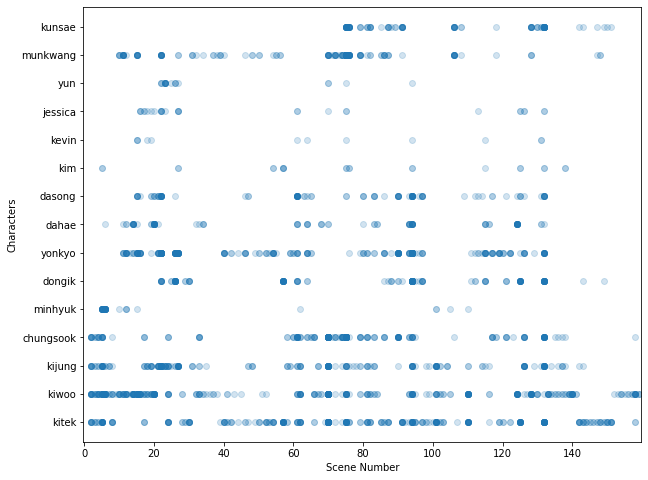

In [301]:
# plotting number of occurences by list of characters
number_scenes = len(character_occurence_index)
number_characters = len(character_list)
plt.subplots(figsize=(10,8))
plt.margins(x=0.005)
plt.yticks(ticks=[i for i in range(number_characters)], labels=character_list)
plt.ylabel("Characters")
plt.xlabel("Scene Number")
plt.scatter([0.5 for i in range(number_characters)], character_list, alpha=0)

for i in range(number_scenes):
    x_array = [(i+1) for j in range(len(character_occurence_index[i]))]
    plt.scatter(x_array, character_occurence_index[i], c="tab:blue", alpha=0.2)

## Character Interactions - Matrix

In [302]:
# getting interactions between characters
character_interactions = np.zeros((number_characters, number_characters))
character_interactions

# goes through each character
for character in character_list:
    idx_i = character_list.index(character)
#     goes through each scene
    for i in range(number_scenes):
        scene_tokens = word_tokenize(df_lem.iloc[i, 2])
#         goes through each word in the scene
        for j in range(len(scene_tokens)):
#             checks if the current word is the character
            if scene_tokens[j] == character:
#                 if so, then iterate over next 20 words to see if another character name appears
                for k in range(j + 1, min(j + 11, len(scene_tokens))):
#                     if another name appears then add 1 to interaction matrix
                    if scene_tokens[k] in character_list:
                        idx_j = character_list.index(scene_tokens[k])
                        character_interactions[idx_i, idx_j] += 1
                        character_interactions[idx_j, idx_i] += 1                

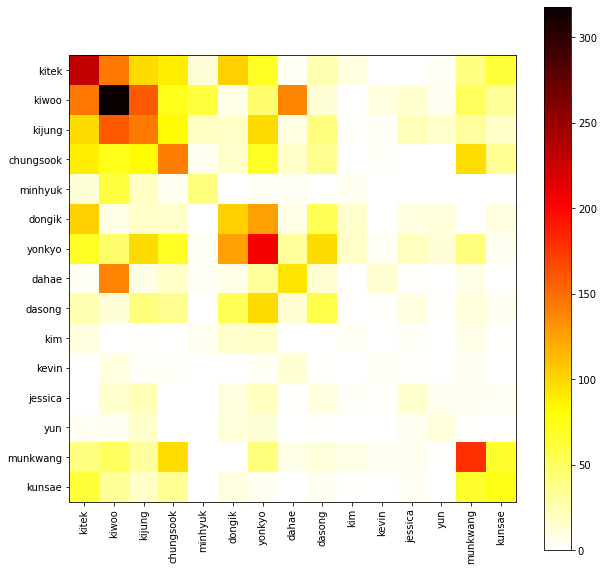

In [303]:
# plotting interactions between characters
plt.figure(figsize=(10,10))
plt.imshow(character_interactions, cmap="hot_r")
plt.xticks([i for i in range(number_characters)], character_list, rotation=90)
plt.yticks([i for i in range(number_characters)], character_list)
plt.colorbar()

## Character Interactions - Network

## Character Interactions - Network (No Splitting of Scenes)

In [304]:
# instantiating network
G = nx.Graph()
node_weights = []

# setting up nodes based on frequency of character interactions
G.add_nodes_from(character_list)
for i in range(number_characters):
    node_weight = 0
    for j in range(number_characters):
        G.add_edge(character_list[i], character_list[j], weight=character_interactions[i][j])
        node_weight += character_interactions[i][j]
    node_weights.append(node_weight*10)

In [305]:
# setting up edges between nodes
edge_weights = []

# edge width based on frequency of character interactions
for i in range(number_characters):
    for j in range(i, number_characters):
        edge_weights.append(character_interactions[i][j])

edge_width = [weight/max(edge_weights) * 10 for weight in edge_weights]

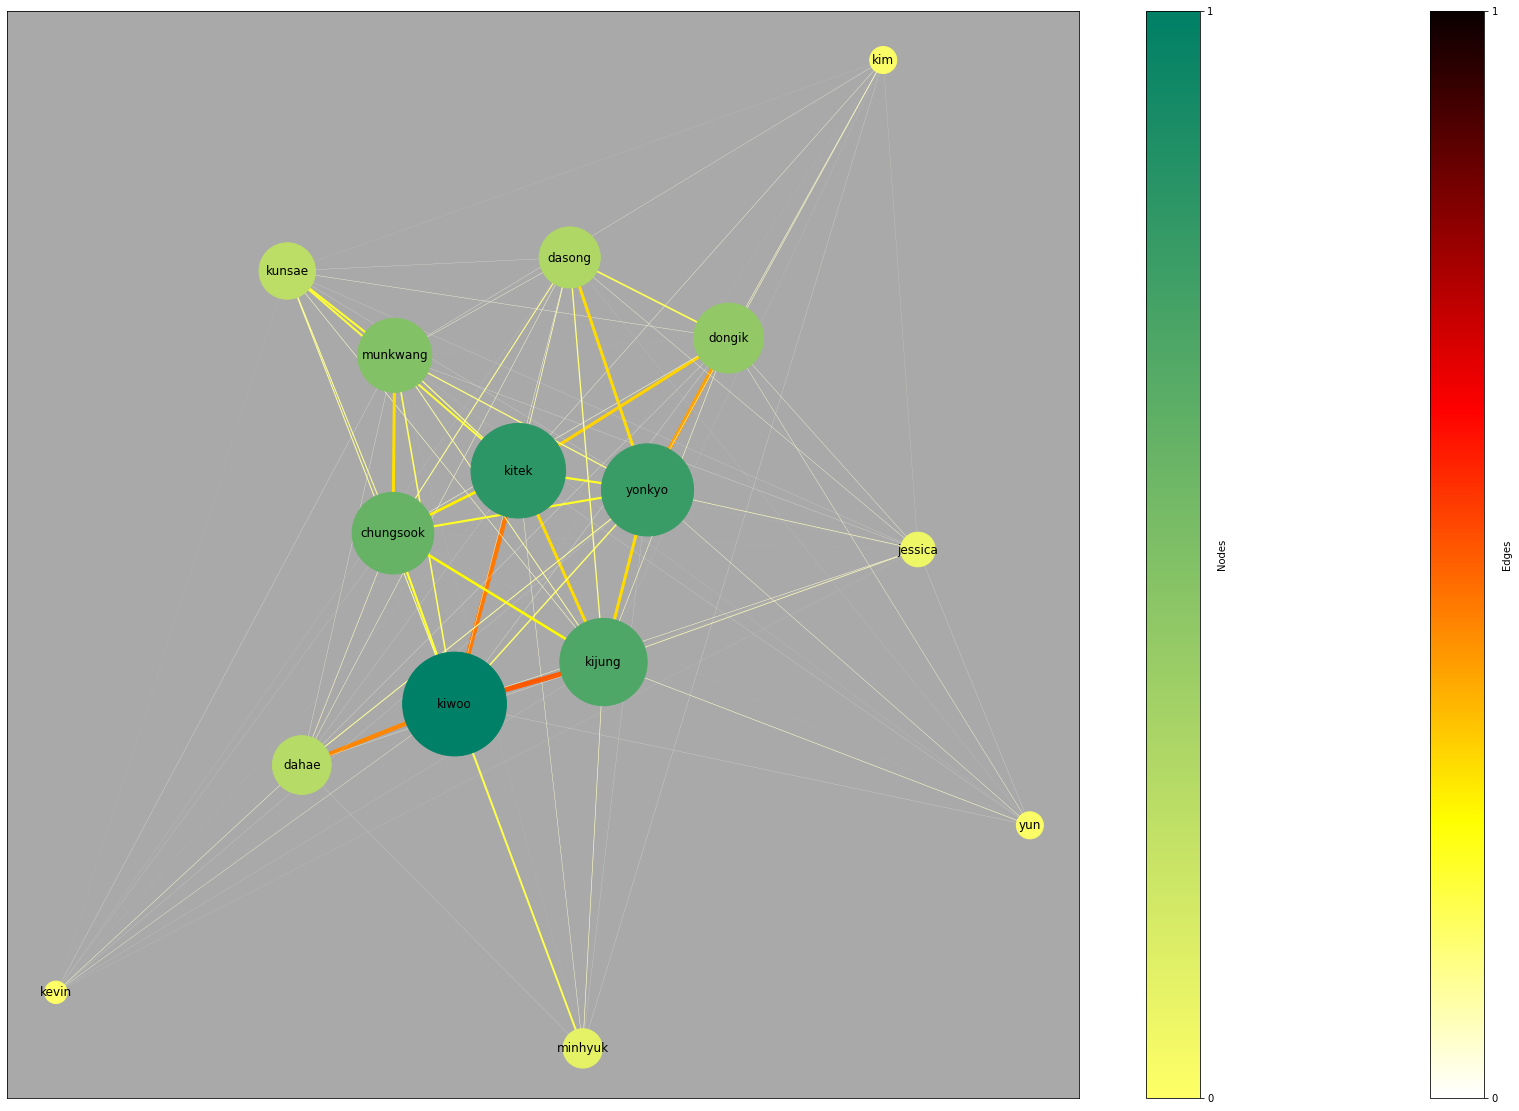

In [600]:
# drawing the network
plt.figure(figsize=(30,20))
nx.draw_networkx(G, node_size=node_weights, node_color=node_weights, cmap="summer_r", edge_color=edge_weights, edge_cmap=plt.cm.get_cmap('hot_r'), width=edge_width)
plt.gca().set_facecolor("darkgrey")

# colorbar for edges
edge_sm = plt.cm.ScalarMappable(cmap="hot_r")
edge_sm._A = []
cbar_edge = plt.colorbar(edge_sm, ticks=[0, 1])
cbar_edge.set_label('Edges')

# colorbar for nodes
node_sm = plt.cm.ScalarMappable(cmap="summer_r")
node_sm._A = []
cbar_node = plt.colorbar(node_sm, ticks=[0, 1])
cbar_node.set_label("Nodes")

## Character Interactions - Network (First Half)

In [337]:
# considering only the first 70 scenes to start
df_first_half = df_lem[df_lem["Scene Number"] <= 70]
character_list_first_half = [character for character in character_list if not character=="kunsae"]
number_characters_first_half = len(character_list_first_half)

# getting interactions between characters
character_interactions_first = np.zeros((number_characters_first_half, number_characters_first_half))
character_interactions_first

# goes through each character
for character in character_list_first_half:
    idx_i = character_list.index(character)
#     goes through each scene
    for i in range(len(df_first_half)):
        scene_tokens = word_tokenize(df_first_half.iloc[i, 2])
#         goes through each word in the scene
        for j in range(len(scene_tokens)):
#             checks if the current word is the character
            if scene_tokens[j] == character:
#                 if so, then iterate over next 10 words to see if another character name appears
                for k in range(j + 1, min(j + 11, len(scene_tokens))):
#                     if another name appears then add 1 to interaction matrix
                    if scene_tokens[k] in character_list:
                        idx_j = character_list.index(scene_tokens[k])
                        character_interactions_first[idx_i, idx_j] += 1
                        character_interactions_first[idx_j, idx_i] += 1                

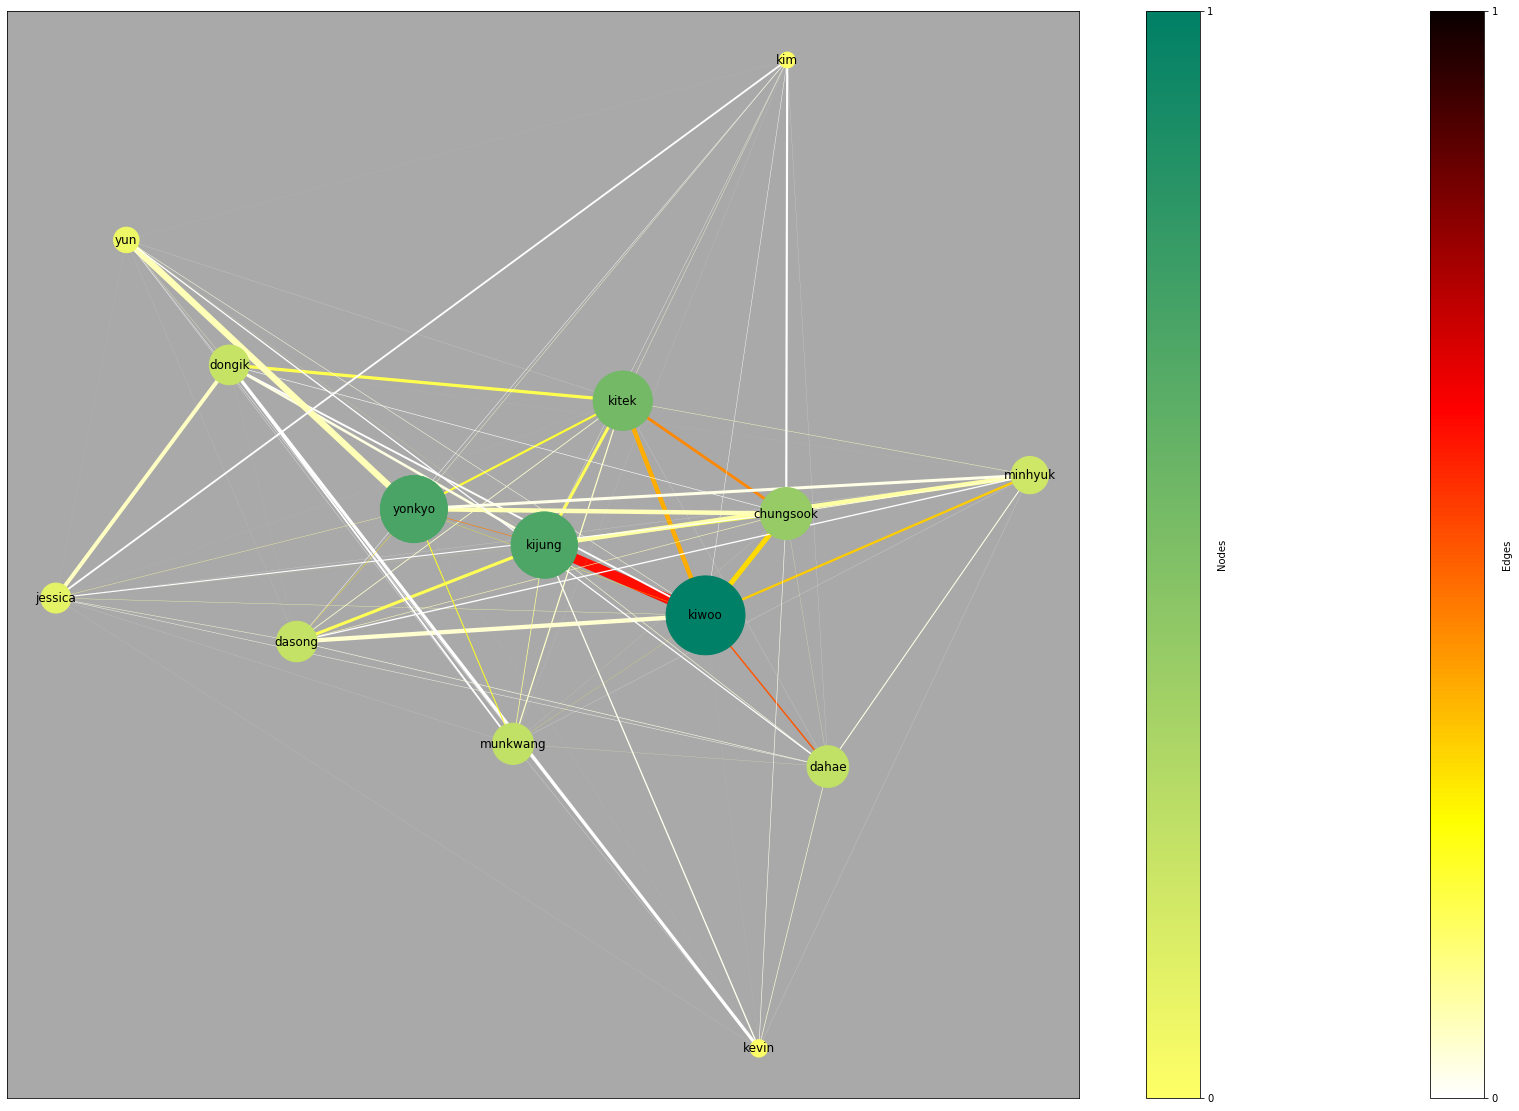

In [350]:
# creating network
G_first = nx.Graph()
node_weights_first = []

G_first.add_nodes_from(character_list_first_half)
for i in range(number_characters_first_half):
    node_weight = 0
    for j in range(number_characters_first_half):
        G_first.add_edge(character_list_first_half[i], character_list_first_half[j], weight=character_interactions_first[i][j])
        node_weight += character_interactions_first[i][j]
    node_weights_first.append(node_weight*10)

# varying edge weight by number of interactions
edge_weights_first = []

for i in range(number_characters_first_half):
    for j in range(i, number_characters_first_half):
        edge_weights_first.append(character_interactions_first[i][j])

edge_width_first = [weight/max(edge_weights_first) * 10 for weight in edge_weights_first]

# plotting network
plt.figure(figsize=(30,20))
plt.gca().set_facecolor("darkgrey")
nx.draw_networkx(G_first, node_size=node_weights_first, node_color=node_weights_first, cmap="summer_r", edge_color=edge_weights_first, edge_cmap=plt.cm.get_cmap('hot_r'), width=edge_width)

# colorbar for edges
edge_sm = plt.cm.ScalarMappable(cmap="hot_r")
edge_sm._A = []
cbar_edge = plt.colorbar(edge_sm, ticks=[0, 1])
cbar_edge.set_label('Edges')

# colorbar for nodes
node_sm = plt.cm.ScalarMappable(cmap="summer_r")
node_sm._A = []
cbar_node = plt.colorbar(node_sm, ticks=[0, 1])
cbar_node.set_label("Nodes")

## Character Interactions - Network (Second Half)

In [323]:
# considering the remaining scenes
df_second_half = df_lem[df_lem["Scene Number"] > 70]

# getting interactions between characters
character_interactions_second = np.zeros((number_characters, number_characters))
character_interactions_second

# goes through each character
for character in character_list:
    idx_i = character_list.index(character)
#     goes through each scene
    for i in range(len(df_second_half)):
        scene_tokens = word_tokenize(df_second_half.iloc[i, 2])
#         goes through each word in the scene
        for j in range(len(scene_tokens)):
#             checks if the current word is the character
            if scene_tokens[j] == character:
#                 if so, then iterate over next 20 words to see if another character name appears
                for k in range(j + 1, min(j + 11, len(scene_tokens))):
#                     if another name appears then add 1 to interaction matrix
                    if scene_tokens[k] in character_list:
                        idx_j = character_list.index(scene_tokens[k])
                        character_interactions_second[idx_i, idx_j] += 1
                        character_interactions_second[idx_j, idx_i] += 1                

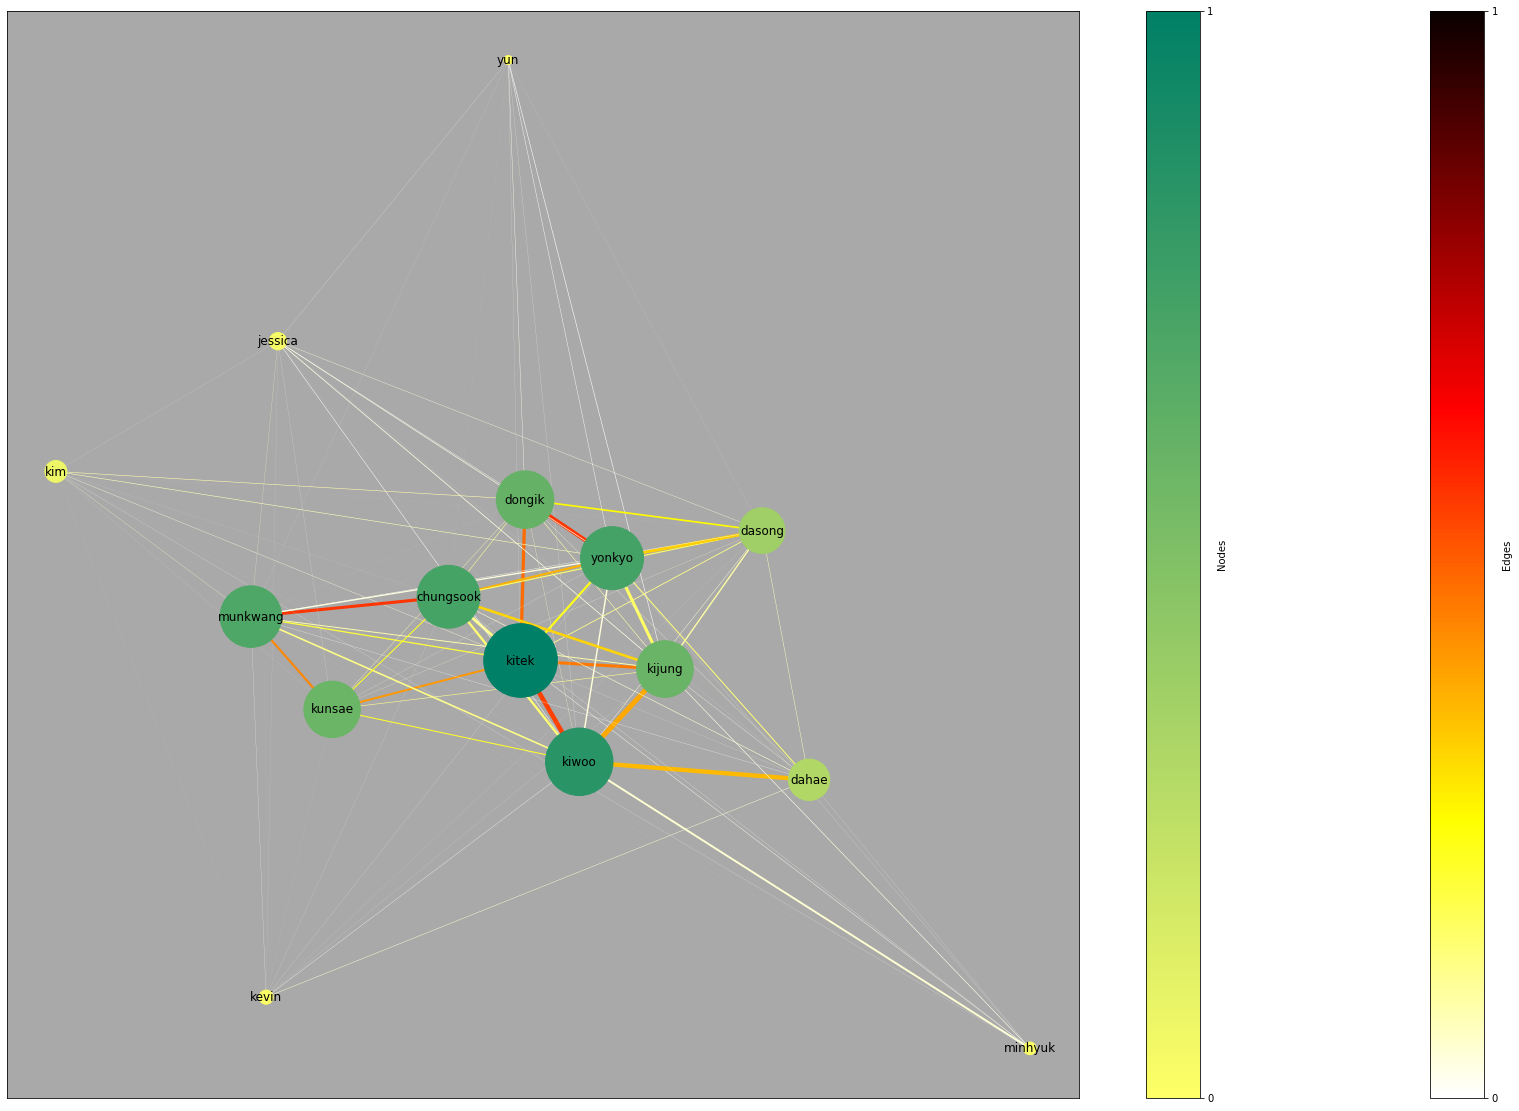

In [351]:
# creating network
G_second = nx.Graph()
node_weights_second = []

G_second.add_nodes_from(character_list)
for i in range(number_characters):
    node_weight = 0
    for j in range(number_characters):
        G_second.add_edge(character_list[i], character_list[j], weight=character_interactions_second[i][j])
        node_weight += character_interactions_second[i][j]
    node_weights_second.append(node_weight*10)

# varying edge weight by number of interactions
edge_weights_second = []

for i in range(number_characters):
    for j in range(i, number_characters):
        edge_weights_second.append(character_interactions_second[i][j])

edge_width_second = [weight/max(edge_weights_second) * 10 for weight in edge_weights_second]

# plotting network
plt.figure(figsize=(30,20))
plt.gca().set_facecolor("darkgrey")
nx.draw_networkx(G_second, node_size=node_weights_second, node_color=node_weights_second, cmap="summer_r", edge_color=edge_weights_second, edge_cmap=plt.cm.get_cmap('hot_r'), width=edge_width)

# colorbar for edges
edge_sm = plt.cm.ScalarMappable(cmap="hot_r")
edge_sm._A = []
cbar_edge = plt.colorbar(edge_sm, ticks=[0, 1])
cbar_edge.set_label('Edges')

# colorbar for nodes
node_sm = plt.cm.ScalarMappable(cmap="summer_r")
node_sm._A = []
cbar_node = plt.colorbar(node_sm, ticks=[0, 1])
cbar_node.set_label("Nodes")

# Story and Theme

## WordCloud - Setting (No Splitting of Scenes) - Bigram

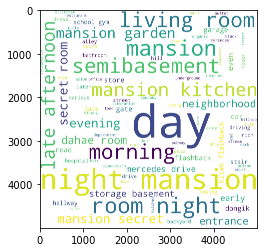

In [354]:
# merging all setting into one string to plot wordcloud
merged_setting = " ".join(df_lem["Setting"])

# plotting wordcloud using WordCloud on merged setting
wordcloud_setting_merged = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_setting)
plt.imshow(wordcloud_setting_merged)

## WordCloud - Scene (No Splitting of Scenes but with removal of Character names)

In [356]:
# adding characters to stopwords list
for character in character_list:
    stopword_list.append(character)

In [357]:
# removing stopwords
df_lem_2  = df_lem.copy()

for i in range(len(df_lem_2)):
#     tokenizing and removing stopwords from scene
    scene_tokens = word_tokenize(df_lem_2.iloc[i, 2])   
    scene_tokens_cleaned = [token for token in scene_tokens if not token in stopword_list]
    cleaned_scene = " ".join(scene_tokens_cleaned)
    df_lem_2.iloc[i, 2] = cleaned_scene
    
df_lem_2.head(5)

,Scene Number,Setting,Scene,length,sentiment,polarity,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
0,1,title sequence black,accompany dark curiously upbeat music end cred...,18,0.2023,-0.033333,0.058824,0.000000,0.000000,0.176471,0.000000,0.294118,0.117647,0.176471,0.058824,0.117647
1,2,semibasement day,dank semibasement apartment run corner corner ...,248,-0.4654,-0.055423,0.033058,0.107438,0.132231,0.107438,0.057851,0.123967,0.181818,0.049587,0.140496,0.066116
2,3,semibasement later,family sit among pile unassembled pizza box fo...,145,-0.3612,0.028704,0.037736,0.056604,0.169811,0.169811,0.037736,0.150943,0.188679,0.018868,0.113208,0.056604
3,4,semibasement entrance late afternoon,halfopen door see female pizza shop owner stan...,227,-0.3400,0.154888,0.045977,0.034483,0.160920,0.183908,0.057471,0.229885,0.080460,0.057471,0.022989,0.126437
4,5,semibasement early evening,‘ master bedroom ’ next entrance wall adorn pi...,374,0.9741,0.034909,0.060241,0.084337,0.108434,0.132530,0.090361,0.228916,0.108434,0.042169,0.018072,0.126506


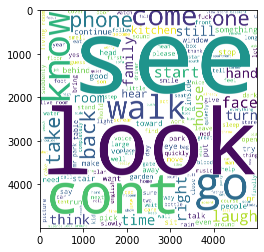

In [358]:
# merging all scenes into one string to plot wordcloud
merged_scene = " ".join(df_lem_2["Scene"])

# plotting wordcloud using WordCloud on merged scene
wordcloud_scene_merged = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_scene)
plt.imshow(wordcloud_scene_merged)

In [601]:
# editing stopword list
stopword_list = stopwords.words("english")
additional_stopwords = ["look", "cont", "see", "go", "know", "back", "right", "come", "walk", "take", "one", "start", "think", "want", "still", "make", "laugh", "face", "vo"]
for words in additional_stopwords:
    stopword_list.append(words)
    
# removing additional stopwords
for i in range(len(df_lem_2)):
#     tokenizing and removing stopwords from scene
    scene_tokens = word_tokenize(df_lem_2.iloc[i, 2])   
    scene_tokens_cleaned = [token for token in scene_tokens if not token in stopword_list]
    cleaned_scene = " ".join(scene_tokens_cleaned)
    df_lem_2.iloc[i, 2] = cleaned_scene

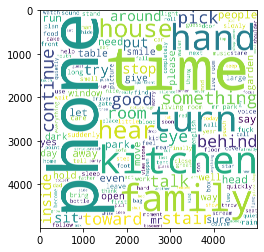

In [459]:
# merging all scenes into one string to plot wordcloud
merged_scene = " ".join(df_lem_2["Scene"])

# plotting wordcloud using WordCloud on merged scenes
wordcloud_scene_merged = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_scene)
plt.imshow(wordcloud_scene_merged)

# Wordcloud - Setting (Splitting Scenes into First and Second Half)

In [603]:
df_first_half = df_lem_2[df_lem_2["Scene Number"] <= 70]
df_second_half = df_lem_2[df_lem_2["Scene Number"] > 70]

### Wordcloud - Setting (First Half) - Bigram

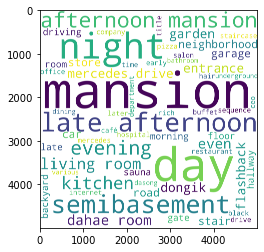

In [463]:
# merging all settings from first half
merged_setting_first = " ".join(df_first_half["Setting"])

# plotting wordcloud using WordCloud on settings of first half of the script
wordcloud_setting_first = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_setting_first)
plt.imshow(wordcloud_setting_first)

### Wordcloud - Setting (Second Half) - Bigram

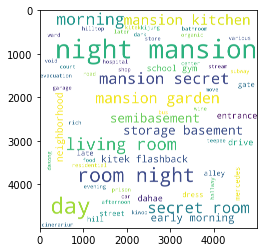

In [464]:
# merging all settings from second half
merged_setting_second = " ".join(df_second_half["Setting"])

# plotting wordcloud using WordCloud on settings of second half of the script
wordcloud_setting_second = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_setting_second)
plt.imshow(wordcloud_setting_second)

# Wordcloud - Scene (Splitting Scenes into First and Second Half)

## Wordcloud - Scene (First Half Without Characters) - Bigram

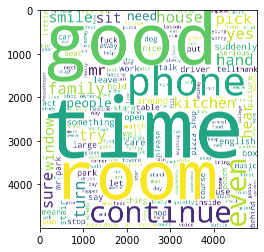

In [467]:
# merging all scene descriptions from the first half of the movie
merged_scene_first = " ".join(df_first_half["Scene"])

# plotting wordcloud using WordCloud on merged scenes from first half
wordcloud_scene_first = WordCloud(width = 5000, height = 5000, min_font_size = 10, background_color="white").generate(merged_scene_first)
plt.imshow(wordcloud_scene_first)

## Wordcloud - Scene (Second Half Without Characters) - Bigram

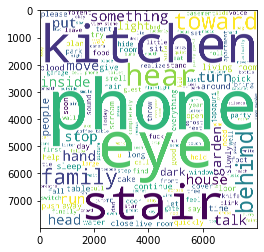

In [604]:
# merging all scene descriptions from the second half of the movie
merged_scene_second = " ".join(df_second_half["Scene"])

# plotting wordcloud using WordCloud on merged scenes from second half
wordcloud_scene_second = WordCloud(width = 8000, height = 8000, min_font_size = 10, background_color="white").generate(merged_scene_second)
plt.imshow(wordcloud_scene_second)

# Story and Theme - Plotting features over scene

In [647]:
# deriving the scene numbers with mentions of "crossing the line" and "smell" - both of which are recurring themes throughout the film
df_lem["line"] = 0
df_lem["smell"] = 0

# counting number of times "line" or "smell" are mentioned
for i in range(len(df_lem)):
    line_count = 0
    smell_count = 0
    words = word_tokenize(df_lem.iloc[i, 2])
    for j in range(len(words) - 1):
        if words[j] == "cross" and words[j + 1] == "line":
            line_count += 1
    for k in range(len(words)):
        if words[k] == "smell":
            smell_count += 1
    df_lem.loc[i, "line"] = line_count
    df_lem.loc[i, "smell"] = smell_count

# normalizing the number of mentions by the min and max to plot them based on number of instances
min_line = min(df_lem["line"])
max_line = max(df_lem["line"])
min_smell = min(df_lem["smell"])
max_smell = max(df_lem["smell"])

line_index = []
line_alpha = []
smell_index = []
smell_alpha = []
for i in range(len(df_lem)):
    df_lem.loc[i, "line"] = (df_lem.loc[i, "line"] - min_line)/(max_line-min_line)
    if df_lem.loc[i, "line"] > 0:
        line_index.append(i + 1)
        line_alpha.append(df_lem.loc[i, "line"])
    
    df_lem.loc[i, "smell"] = (df_lem.loc[i, "smell"] - min_smell)/(max_smell-min_smell)
    if df_lem.loc[i, "smell"] > 0:
        smell_index.append(i + 1)
        smell_alpha.append(df_lem.loc[i, "smell"])

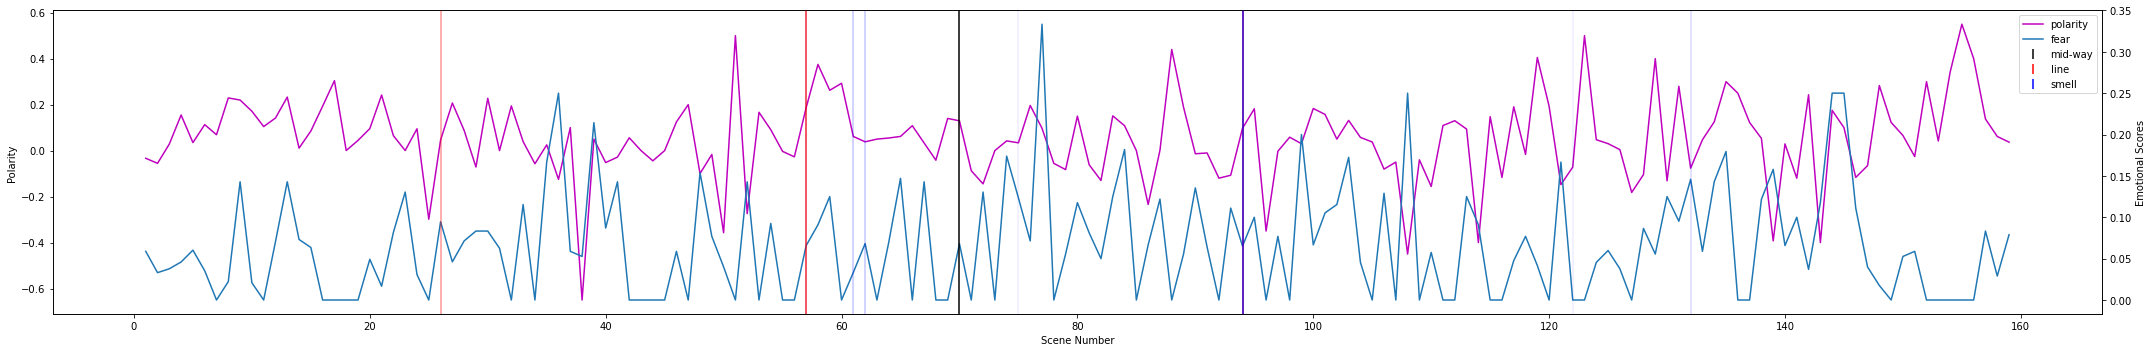

In [672]:
# plotting polarity and fear throughout the film
emotions_1 = ["fear"]

fig, ax1 = plt.subplots(figsize=(30,5))
color = 'm'
ax1.set_xlabel('Scene Number')
ax1.set_ylabel('Polarity')
pol_line = ax1.plot(df_lem["Scene Number"], df_lem["polarity"], color=color, label="polarity")
ax1.tick_params(axis='y')
lns = pol_line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Emotional Scores')  # we already handled the x-label with ax1
for emotion in emotions_1:
    emotion_line = ax2.plot(df_lem["Scene Number"], df_lem[emotion], label=emotion)
    lns += emotion_line
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
midway_line = plt.axvline(x=70, c="k", label="mid-way")
lns.append(Line2D([], [], color='k', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='mid-way'))


# plotting the scenes which mentions "crossing the line" or "smell" coloured by the frequency of mentions in that scene
for i in range(len(line_index)):
    cross_line = plt.axvline(x=line_index[i], c="r", alpha=line_alpha[i]/1.2, label="line")
lns.append(Line2D([], [], color='r', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='line'))
    
for j in range(len(smell_index)):
    smell_line = plt.axvline(x=smell_index[j], c="b", alpha=smell_alpha[j]/1.2, label="smell")
lns.append(Line2D([], [], color='b', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='smell'))

labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plt.show()

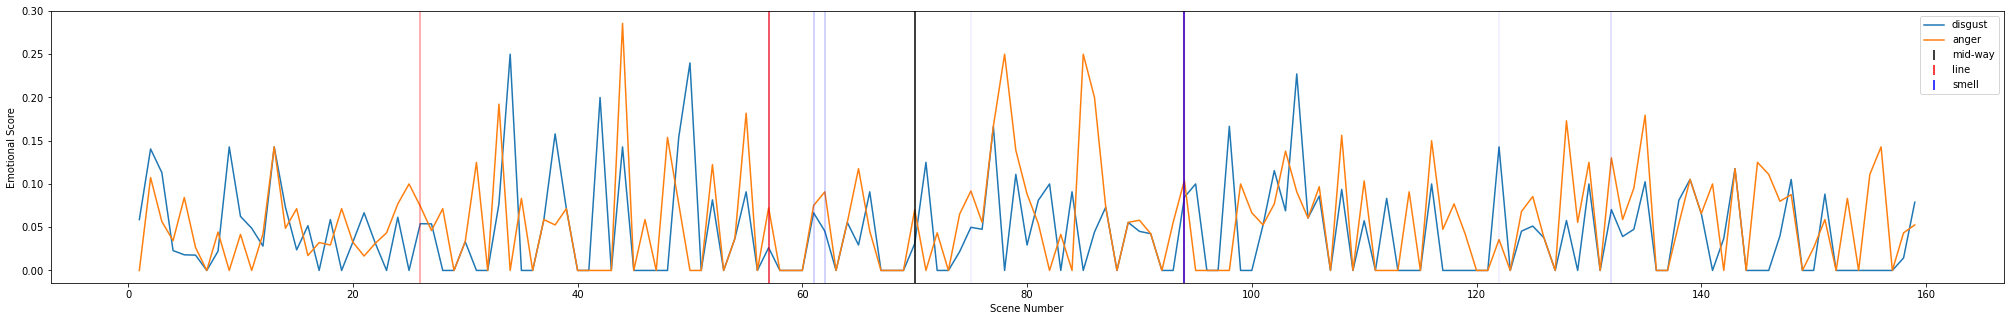

In [679]:
# doing the same but now with disgust and anger
emotions_1 = ["disgust", "anger"]
plt.figure(figsize=(35,5))
plt.xlabel("Scene Number")
plt.ylabel("Emotional Score")
lns_2 = []

for emotion in emotions_1:
    emotion_line = plt.plot(df_lem["Scene Number"], df_lem[emotion], label=emotion)
    lns_2 += emotion_line

midway_line = plt.axvline(x=70, c="k", label="mid-way")
lns_2.append(Line2D([], [], color='k', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='mid-way'))


# plotting the scenes which mentions "crossing the line" or "smell" coloured by the frequency of mentions in that scene
for i in range(len(line_index)):
    cross_line = plt.axvline(x=line_index[i], c="r", alpha=line_alpha[i]/1.2, label="line")
lns_2.append(Line2D([], [], color='r', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='line'))
    
for j in range(len(smell_index)):
    smell_line = plt.axvline(x=smell_index[j], c="b", alpha=smell_alpha[j]/1.2, label="smell")
lns_2.append(Line2D([], [], color='b', marker='|', linestyle='None', markersize=10, markeredgewidth=1.5, label='smell'))

labs_2 = [l.get_label() for l in lns_2]
plt.legend(lns_2, labs_2)
    
plt.show()

## Comparing means

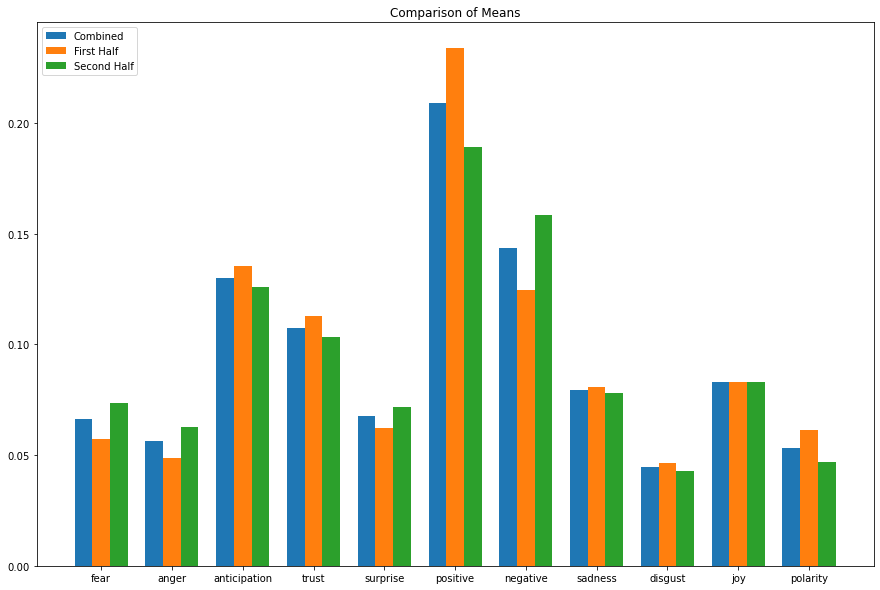

In [457]:
# comparing means of each emotion in the first and second half of the film
emotions = ["fear", "anger", "anticipation", "trust", "surprise", "positive", "negative", "sadness", "disgust", "joy"]
emotions.append("polarity")

# getting means of each emotion throughout the whole film, first and second half of the film
emotions_means = [df_lem[emotion].mean() for emotion in emotions]
emotions_means_first = [df_first_half[emotion].mean() for emotion in emotions]
emotions_means_second = [df_second_half[emotion].mean() for emotion in emotions]

# plotting and comparing them on a single plot
width = 0.5
index_num = [2*(i+1) for i in range(len(emotions))]
index_num_first = [2*(i+1)+width for i in range(len(emotions))]
index_num_second = [2*(i+1)+2*width for i in range(len(emotions))]
plt.figure(figsize=(15, 10))
plt.bar(index_num, emotions_means, width=width)
plt.bar(index_num_first, emotions_means_first, width=width, tick_label=emotions)
plt.bar(index_num_second, emotions_means_second, width=width)
plt.title("Comparison of Means")
plt.legend(["Combined", "First Half", "Second Half"], loc=2)
plt.show()